# Principal Component Analysis and DFM

> Realizando a análise de componentes principais e posteriormente aplicando o primeiro modelo DFM para os dados

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [3]:
pio.renderers.default = 'browser'

# Funções

In [4]:
# Função para realizar o teste ADF 1

def adfuller_test1(series, signif = 0.05):

# Perform Augmented Dickey-Fuller to test for Stationarity of the given series
# and print report. Null Hypothesis [H0]: Data has unit root and is non-stationary.

# series: time series in pd.Series format
# signif: significance level for P-value to reject Null Hypothesis

    x = adfuller(series, 
                 regression = 'n',            # sem constante e sem termo de tendência determinística
                 autolag = 'BIC')              # inserindo o critério bayesiano de informação para determinaro 
                                               # número de lags em cada regressão do teste
                                               # Seguimos com o critério BIC para a inclusão automática de lags como feito em Issler (2016).

    #using dictionary saves different data types (float, int, boolean)
    output = {'test_statistic': x[0], 
              'p_value': x[1], 
              'n_lags': x[2], 
              'n_observations': x[3],
              f'reject_005': x[1] < signif }

    for key, val in x[4].items():
         output[f'Critical value {key}'] = val

    return pd.Series(output)

In [5]:
# Função para realizar o teste ADF 2

def adfuller_test2(series, signif = 0.05):

# Perform Augmented Dickey-Fuller to test for Stationarity of the given series
# and print report. Null Hypothesis [H0]: Data has unit root and is non-stationary.

# series: time series in pd.Series format
# signif: significance level for P-value to reject Null Hypothesis

    x = adfuller(series, 
                 regression = 'c',            # inserindo apenas a constante
                 autolag = 'BIC')              # inserindo o critério bayesiano de informação para determinaro 
                                               # número de lags em cada regressão do teste
                                               # Seguimos com o critério BIC para a inclusão automática de lags como feito em Issler (2016).

    #using dictionary saves different data types (float, int, boolean)
    output = {'test_statistic': x[0], 
              'p_value': x[1], 
              'n_lags': x[2], 
              'n_observations': x[3],
              f'reject_005': x[1] < signif }

    for key, val in x[4].items():
         output[f'Critical value {key}'] = val

    return pd.Series(output)

In [6]:
# Definindo a função para realizar o ADF test 

def adfuller_test3(series, signif = 0.05):

# Perform Augmented Dickey-Fuller to test for Stationarity of the given series
# and print report. Null Hypothesis [H0]: Data has unit root and is non-stationary.

# series: time series in pd.Series format
# signif: significance level for P-value to reject Null Hypothesis

    x = adfuller(series, 
                 regression = 'ct',            # inserindo uma constante e um termo de tendência na regressão
                 autolag = 'BIC')              # inserindo o critério bayesiano de informação para determinaro 
                                               # número de lags em cada regressão do teste
                                               # Seguimos com o critério BIC para a inclusão automática de lags como feito em Issler (2016).

    #using dictionary saves different data types (float, int, boolean)
    output = {'test_statistic': x[0], 
              'p_value': x[1], 
              'n_lags': x[2], 
              'n_observations': x[3],
              f'reject_005': x[1] < signif }

    for key, val in x[4].items():
         output[f'Critical value {key}'] = val

    return pd.Series(output)

# Lendo os dados

In [7]:
data = pd.read_csv('../../data/data_full_tf12.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
data.drop('gdp', axis = 1, inplace = True)
# data.rename(columns={'retail_sales':'com_sales'}, inplace=True)
data

,ibc_br,mon_gdp,ind_prod,ind_prod_ext,ind_prod_transf,ind_cap_goods,ind_prod_int_goods,ind_prod_man,ind_prod_dur_goods,ind_prod_nondur_goods,...,gt_politica,gt_aluguel,gt_seguro,gt_governo,gt_viagem,gt_empreendedor,gt_empresa,gt_credito,gt_dolar,gt_financiamento
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,2.45,29367.7,0.7,2.8,0.8,3.8,0.3,0.8,2.3,0.5,...,0.375,0.750,0.375,0.000,1.375,-0.250,-1.125,0.000,2.375,1.250
2002-02-01,2.45,29367.7,0.7,2.8,0.8,3.8,0.3,0.8,2.3,0.5,...,0.375,0.750,0.375,0.000,1.375,-0.250,-1.125,0.000,2.375,1.250
2002-03-01,2.45,29367.7,0.7,2.8,0.8,3.8,0.3,0.8,2.3,0.5,...,0.375,0.750,0.375,0.000,1.375,-0.250,-1.125,0.000,2.375,1.250
2002-04-01,2.45,29367.7,0.7,2.8,0.8,3.8,0.3,0.8,2.3,0.5,...,0.375,0.750,0.375,0.000,1.375,-0.250,-1.125,0.000,2.375,1.250
2002-05-01,2.45,29367.7,0.7,2.8,0.8,3.8,0.3,0.8,2.3,0.5,...,0.375,0.750,0.375,0.000,1.375,-0.250,-1.125,0.000,2.375,1.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,5.07,101660.0,-0.3,-10.4,1.3,6.4,-2.3,2.2,-3.4,3.4,...,-1.000,10.625,-4.125,4.875,11.125,-6.625,-2.125,-0.625,26.625,-3.875
2022-06-01,4.44,102487.4,-0.6,-5.9,0.2,-0.4,-3.0,3.8,2.0,4.0,...,-1.000,7.500,4.000,2.750,8.500,2.000,2.375,-8.875,-2.375,-9.750
2022-07-01,6.44,99509.7,-0.4,-4.3,0.2,-6.6,-1.8,3.7,-0.8,4.0,...,1.125,7.625,-4.125,0.000,12.500,2.250,-1.750,-1.375,7.875,-7.375


In [8]:
# Lendo meta_data

meta_data = pd.read_csv('../../data/meta-data-full.csv')
# meta_data.drop(['tcode', 'transf_code'], axis = 1, inplace = True)
meta_data

,group,category,code,name_df,name,source,frequency,original,order,transf,days_lag,where
0,0,Production,22099,gdp,PIB trimestral - Dados observados - preços de ...,IBGE,Q,Index,NaN,pctchg_12,63.0,BCB
1,0,Production,24363,ibc_br,Índice de Atividade Econômica do Banco Central...,BCB,M,Index,NaN,diff_12,52.0,BCB
2,0,Production,4380,mon_gdp,PIB mensal - Valores correntes (R$ milhões)\t,BCB,M,R$,NaN,diff_12,48.0,BCB
3,0,Production,21859,ind_prod,Indicadores da produção (2012=100) - Produção ...,IBGE,M,Index,NaN,diff_12,30.0,BCB
4,0,Production,21861,ind_prod_ext,Indicadores da produção (2012=100) - Produção ...,IBGE,M,Index,NaN,diff_12,30.0,BCB
...,...,...,...,...,...,...,...,...,...,...,...,...
190,9,Google Trends,empreendedor,gt_empreendedor,Google Trends - Empreendedor,Google,M,Trend Index,NaN,diff_diff_12,NaN,gtrendsR
191,9,Google Trends,abrir empresa,gt_empresa,Google Trends - Abrir empresa,Google,M,Trend Index,NaN,diff_12,NaN,gtrendsR
192,9,Google Trends,credito,gt_credito,Google Trends - Crédito,Google,M,Trend Index,NaN,diff_diff_12,NaN,gtrendsR
193,9,Google Trends,dolar,gt_dolar,Google Trends - Dólar,Google,M,Trend Index,NaN,diff_12,NaN,gtrendsR


# Categorias dos dados

In [9]:
series_groups = meta_data[['group', 'category']].copy()
counts = series_groups.groupby(['group', 'category']).size().values
groups = series_groups['group'].unique()
cats = series_groups['category'].unique()

series_groups = pd.DataFrame({'Grupos':groups, 'Categoria':cats, 'Número de séries':counts})
print(series_groups.to_latex(index = False))

\begin{tabular}{rlr}
\toprule
 Grupos &     Categoria &  Número de séries \\
\midrule
      0 &    Production &                20 \\
      1 &  Labor Market &                10 \\
      2 &         Sales &                19 \\
      3 &        Energy &                14 \\
      4 &  Expectations &                19 \\
      5 & International &                 9 \\
      6 & Public Sector &                 9 \\
      7 &        Prices &                25 \\
      8 &     Financial &                20 \\
      9 & Google Trends &                50 \\
\bottomrule
\end{tabular}



C:\Users\Henri\AppData\Local\Temp\ipykernel_2104\2712447795.py:7: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [10]:
# Criando df para mapear grupo no dataframe de contribuição dos componentes

map_comp = meta_data[['category', 'name_df']].copy()
map_comp.set_index('name_df', inplace = True)
map_comp = map_comp.iloc[1:]
map_comp

,category
name_df,
ibc_br,Production
mon_gdp,Production
ind_prod,Production
ind_prod_ext,Production
ind_prod_transf,Production
...,...
gt_empreendedor,Google Trends
gt_empresa,Google Trends
gt_credito,Google Trends


# PCA

In [11]:
# Definindo caminhos e variáveis necessárias para o PCA e padronizando as variáveis 

cols = data.columns
ind = data.index
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
data_scaled = pd.DataFrame(scaled_data, columns = cols, index = ind)
data_scaled

,ibc_br,mon_gdp,ind_prod,ind_prod_ext,ind_prod_transf,ind_cap_goods,ind_prod_int_goods,ind_prod_man,ind_prod_dur_goods,ind_prod_nondur_goods,...,gt_politica,gt_aluguel,gt_seguro,gt_governo,gt_viagem,gt_empreendedor,gt_empresa,gt_credito,gt_dolar,gt_financiamento
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,0.041637,-0.197382,0.044468,0.187678,0.060854,0.115885,0.018623,0.066811,0.082088,0.053998,...,0.028033,0.062306,0.067846,-0.031851,0.059224,-0.019117,-0.001308,0.010384,-0.073080,0.005860
2002-02-01,0.041637,-0.197382,0.044468,0.187678,0.060854,0.115885,0.018623,0.066811,0.082088,0.053998,...,0.028033,0.062306,0.067846,-0.031851,0.059224,-0.019117,-0.001308,0.010384,-0.073080,0.005860
2002-03-01,0.041637,-0.197382,0.044468,0.187678,0.060854,0.115885,0.018623,0.066811,0.082088,0.053998,...,0.028033,0.062306,0.067846,-0.031851,0.059224,-0.019117,-0.001308,0.010384,-0.073080,0.005860
2002-04-01,0.041637,-0.197382,0.044468,0.187678,0.060854,0.115885,0.018623,0.066811,0.082088,0.053998,...,0.028033,0.062306,0.067846,-0.031851,0.059224,-0.019117,-0.001308,0.010384,-0.073080,0.005860
2002-05-01,0.041637,-0.197382,0.044468,0.187678,0.060854,0.115885,0.018623,0.066811,0.082088,0.053998,...,0.028033,0.062306,0.067846,-0.031851,0.059224,-0.019117,-0.001308,0.010384,-0.073080,0.005860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,0.521809,2.783785,-0.095869,-1.377957,0.127138,0.278556,-0.394280,0.240101,-0.181444,0.588138,...,-0.131931,1.872678,-0.950872,0.376206,1.167360,-0.766111,-0.101513,-0.143515,2.387003,-0.666321
2022-06-01,0.406348,2.817905,-0.137970,-0.844217,-0.018687,-0.146891,-0.505446,0.438147,0.068218,0.698650,...,-0.131931,1.299775,0.888481,0.198335,0.869016,0.244527,0.349411,-2.174974,-0.554952,-1.436870
2022-07-01,0.772891,2.695112,-0.109903,-0.654444,-0.018687,-0.534799,-0.314876,0.425769,-0.061236,0.698650,...,0.115286,1.322692,-0.950872,-0.031851,1.323636,0.273821,-0.063936,-0.328193,0.484877,-1.125372


In [12]:
data_scaled.corr().round(3)

,ibc_br,mon_gdp,ind_prod,ind_prod_ext,ind_prod_transf,ind_cap_goods,ind_prod_int_goods,ind_prod_man,ind_prod_dur_goods,ind_prod_nondur_goods,...,gt_politica,gt_aluguel,gt_seguro,gt_governo,gt_viagem,gt_empreendedor,gt_empresa,gt_credito,gt_dolar,gt_financiamento
ibc_br,1.000,0.528,0.906,0.437,0.904,0.848,0.818,0.858,0.819,0.811,...,0.073,0.090,0.029,-0.128,0.366,0.104,0.164,0.150,-0.229,-0.205
mon_gdp,0.528,1.000,0.398,0.019,0.420,0.497,0.341,0.352,0.324,0.340,...,0.044,0.277,0.013,-0.185,0.444,0.073,0.072,0.099,-0.015,-0.434
ind_prod,0.906,0.398,1.000,0.500,0.993,0.868,0.955,0.910,0.892,0.839,...,0.070,0.041,-0.014,-0.134,0.246,0.102,0.112,0.138,-0.263,-0.093
ind_prod_ext,0.437,0.019,0.500,1.000,0.400,0.326,0.596,0.315,0.318,0.284,...,-0.012,-0.026,0.067,0.062,0.118,-0.008,0.139,0.058,-0.063,0.146
ind_prod_transf,0.904,0.420,0.993,0.400,1.000,0.878,0.933,0.923,0.903,0.853,...,0.077,0.044,-0.027,-0.153,0.244,0.108,0.099,0.138,-0.270,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gt_empreendedor,0.104,0.073,0.102,-0.008,0.108,0.100,0.047,0.166,0.148,0.165,...,0.069,0.028,0.120,0.068,-0.033,1.000,0.138,0.144,0.067,0.058
gt_empresa,0.164,0.072,0.112,0.139,0.099,0.091,0.110,0.095,0.106,0.074,...,0.159,0.043,-0.013,0.054,0.006,0.138,1.000,0.010,0.053,0.015
gt_credito,0.150,0.099,0.138,0.058,0.138,0.156,0.104,0.158,0.145,0.157,...,-0.124,0.121,0.273,0.009,0.086,0.144,0.010,1.000,-0.064,0.076
gt_dolar,-0.229,-0.015,-0.263,-0.063,-0.270,-0.164,-0.230,-0.310,-0.333,-0.256,...,0.021,0.062,-0.025,0.050,-0.090,0.067,0.053,-0.064,1.000,0.116


In [13]:
# PCA 

pca = PCA(n_components=9)
pca.fit(data_scaled)
print('Número de componentes =', pca.n_components_)

Número de componentes = 9


In [14]:
data_pca = pca.fit_transform(data_scaled)
data_pca *= -1
data_pca

array([[ 0.3168671 , -0.09148841,  0.2094815 , ...,  0.12225982,
         0.14724797,  0.13107649],
       [ 0.3168671 , -0.09148841,  0.2094815 , ...,  0.12225982,
         0.14724797,  0.13107649],
       [ 0.31631452, -0.09276872,  0.21145233, ...,  0.1233289 ,
         0.14588438,  0.12897475],
       ...,
       [-1.3620783 , -5.48858007,  6.52024284, ...,  1.53852504,
        -1.24165796, -1.04752192],
       [ 1.15337907, -7.58874048,  2.97008098, ...,  0.08741924,
        -5.05129865,  1.77746416],
       [-0.45111437, -6.9678171 ,  2.07327166, ...,  1.54664216,
        -0.46045122,  2.52066012]])

# Analisando outputs do PCA

sklearn.PCA muda o sinal dos autovetores epor isso precisamos corrigir o sinal na parte dos dados transformados. Contudo, a parte da variância explicada 
e a interpretação não muda. 

LINKS:

- https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative

- https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/utils/extmath.py#L500

- https://github.com/scikit-learn/scikit-learn/blob/4c65d8e/sklearn/decomposition/pca.py#L391

In [15]:
'''U, S, V = np.linalg.svd(data_scaled, full_matrices=False)
V
eigen_vectors
eig_val, eig_vec = np.linalg.eig(data_scaled.corr())
print('Eigenvalues = ', eig_val)
print('Eigenvectors = ', eig_vec)'''

"U, S, V = np.linalg.svd(data_scaled, full_matrices=False)\nV\neigen_vectors\neig_val, eig_vec = np.linalg.eig(data_scaled.corr())\nprint('Eigenvalues = ', eig_val)\nprint('Eigenvectors = ', eig_vec)"

In [16]:
# Definindo os outputs desejados 

n_components = pca.n_components_
eigen_values = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
components = [f'C{i+1}' for i in range(n_components)]
cum_exp_var_ratio = [sum(exp_var_ratio[0:i+1]) for i in range(n_components)]
cum_eigen_values = [sum(eigen_values[0:i+1]) for i in range(n_components)]
eigen_vectors = pca.components_ * -1

In [17]:
# Criando DF com os dados tranformados por PCA

data_pca_df = pd.DataFrame(data_pca, columns = components, index = ind)
data_pca_df.to_csv('../../data/data_tf_fullpca12.csv')
data_pca_df

,C1,C2,C3,C4,C5,C6,C7,C8,C9
Date,,,,,,,,,
2002-01-01,0.316867,-0.091488,0.209481,-0.049668,0.420044,-0.007896,0.122260,0.147248,0.131076
2002-02-01,0.316867,-0.091488,0.209481,-0.049668,0.420044,-0.007896,0.122260,0.147248,0.131076
2002-03-01,0.316315,-0.092769,0.211452,-0.051712,0.422323,-0.010645,0.123329,0.145884,0.128975
2002-04-01,0.321442,-0.080889,0.193166,-0.032748,0.401177,0.014861,0.113409,0.158536,0.148476
2002-05-01,0.317839,-0.089236,0.206014,-0.046072,0.416034,-0.003059,0.120379,0.149647,0.134774
...,...,...,...,...,...,...,...,...,...
2022-05-01,0.731735,-4.961002,3.975562,-5.039646,-2.123943,2.485194,0.601675,-5.596278,-3.264406
2022-06-01,-0.073543,-1.638612,2.460036,-7.086180,-0.958716,-1.582263,3.161348,-0.631744,3.438681
2022-07-01,-1.362078,-5.488580,6.520243,-0.867184,-3.454676,0.304343,1.538525,-1.241658,-1.047522


In [18]:
data_pca_df.corr().round(3)

,C1,C2,C3,C4,C5,C6,C7,C8,C9
C1,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
C2,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
C3,-0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
C4,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0
C5,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,0.0
C6,-0.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,-0.0
C7,-0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0
C8,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0
C9,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0


In [19]:
# Inserindo principais informações em um Data Frame

pca_summary = pd.DataFrame({'component':components, 'eigenvalue':eigen_values.round(6), 'cum_eigen_values':cum_eigen_values, 
                            'explained_var_ratio':exp_var_ratio.round(6), 'cummulated_var':cum_exp_var_ratio})
pca_summary

# eigenvalue: quanto do total DA VARIÂNCIA explicada por todos os componentes cada componente explica? 
# C1, por exemplo, resume 18% do toal da variância explicada pelos 83 componentes principais - (155 variáveis resumidas em 83 PC's)
# explained variance: quanto do total de variáveis cada componente explica: C1, por exemplo, "explica bem" 34 das 155 variáveis do conjunto total
# explained variance ratio: quanto do total da variância explicada cada componente representa

,component,eigenvalue,cum_eigen_values,explained_var_ratio,cummulated_var
0,C1,37.307948,37.307948,0.191537,0.191537
1,C2,12.667256,49.975204,0.065033,0.256570
2,C3,11.020854,60.996059,0.056580,0.313150
3,C4,10.469288,71.465347,0.053749,0.366899
4,C5,8.962001,80.427348,0.046010,0.412909
5,C6,8.003162,88.430509,0.041088,0.453997
6,C7,7.127233,95.557742,0.036591,0.490588
7,C8,6.388827,101.946569,0.032800,0.523387
8,C9,5.111981,107.058550,0.026245,0.549632


In [20]:
# Construindo o Data Frame com os autovetores associados aos maiores autovalores 

eigvectors_df = pd.DataFrame(eigen_vectors, columns = cols, index = [f'eigvector_{i+1}' for i in range(n_components)])
eigvectors_df = eigvectors_df.head(13)

In [21]:
# Construindo o DF da correlação de cada variável com os componentes principais
# A correlação é dada pela multiplicação entre o peso da variável no componete principal (expressado pelo seu respectivo coeficiente nos autovetores)
# e o desvio padrão explicado por cada componete

eigen_values_sqrt = np.sqrt(eigen_values)
contrib_components = pd.DataFrame(eigen_vectors.T * eigen_values_sqrt, columns = components, index = cols)
contrib_components = pd.merge(contrib_components, map_comp, left_index=True, right_index=True)
contrib_components

,C1,C2,C3,C4,C5,C6,C7,C8,C9,category
ibc_br,0.918966,-0.215702,0.036015,-0.149299,0.188152,-0.013716,0.031106,-0.005112,-0.002699,Production
mon_gdp,0.562775,-0.016453,0.089416,-0.411518,-0.321500,0.095769,-0.113781,-0.140859,-0.191654,Production
ind_prod,0.926250,-0.056681,-0.073855,0.050111,0.151723,-0.038377,0.102859,-0.163072,0.046984,Production
ind_prod_ext,0.329018,-0.116161,-0.007555,-0.039328,0.256601,-0.192571,0.076251,-0.160768,0.160703,Production
ind_prod_transf,0.938204,-0.048678,-0.080329,0.055693,0.126707,-0.016330,0.100363,-0.147881,0.025423,Production
...,...,...,...,...,...,...,...,...,...,...
gt_empreendedor,0.118218,-0.129813,-0.087352,0.071616,-0.016562,0.337222,-0.182973,-0.126862,0.036154,Google Trends
gt_empresa,0.130006,-0.148284,0.050263,0.097269,0.098608,0.039640,-0.330129,-0.002397,0.054462,Google Trends
gt_credito,0.167201,-0.088826,-0.000634,0.087400,-0.009220,0.152587,-0.129583,-0.053977,-0.106259,Google Trends
gt_dolar,-0.318223,0.042337,-0.055194,-0.346040,0.097234,0.118247,-0.169480,-0.159553,0.034164,Google Trends


In [22]:
# Variáveis que mais contribuem com os 5 primeiros componentes principais

# C1

contrib_c1 = abs(contrib_components.drop('category', axis = 1)).sort_values(by = 'C1', ascending = False)
contrib_c1 = contrib_c1.query('C1 > 0.5')
vars_c1 = list(contrib_c1.index)
top_c1 = list(contrib_c1['C1'].values)

# C2

contrib_c2 = abs(contrib_components.drop('category', axis = 1)).sort_values(by = 'C2', ascending = False)
contrib_c2 = contrib_c2.query('C2 > 0.5')
vars_c2 = list(contrib_c2.index)
top_c2 = list(contrib_c2['C2'].values)

# C3

contrib_c3 = abs(contrib_components.drop('category', axis = 1)).sort_values(by = 'C3', ascending = False)
contrib_c3 = contrib_c3.query('C3 > 0.5')
vars_c3 = list(contrib_c3.index)
top_c3 = list(contrib_c3['C3'].values)


# C4

contrib_c4 = abs(contrib_components.drop('category', axis = 1)).sort_values(by = 'C4', ascending = False)
contrib_c4 = contrib_c4.query('C4 > 0.5')
vars_c4 = list(contrib_c4.index)
top_c4 = list(contrib_c4['C4'].values)


# C5

contrib_c5 = abs(contrib_components.drop('category', axis = 1)).sort_values(by = 'C5', ascending = False)
contrib_c5 = contrib_c5.query('C5 > 0.5')
vars_c5 = list(contrib_c5.index)
top_c5 = list(contrib_c5['C5'].values)

In [23]:
contrib_c3.C3.sum()

6.163154499374966

## Visualizações 

In [24]:
# Plotando os autovalores: quantas variáveis das 155 do conjunto de dados são explicados pelos 83 componentes principais?

top_components = components[:9]
top_eigvalues = eigen_values[:9]
top_cum_eigvalues = cum_eigen_values[:9]

fig = px.line(x = top_components, y = top_cum_eigvalues, text = np.around(top_cum_eigvalues, 2),
             title = ' ')
fig.update_layout(yaxis = {'title':'Autovalores', 'tickfont':{'size':13}},
                  xaxis = {'title':'Componentes', 'tickfont':{'size':13}},
                  title = {'font':{'size':20}})
fig.add_bar(x = top_components, y = top_eigvalues, text = np.around(eigen_values, 2))
fig.show()

In [ ]:
# Plotando a porcentagem da variância explicada: quanto da variância total é explicada por cada componente?

top_components = components[:9]
top_expvar_ratio = exp_var_ratio[:9]
top_cum_expvar_ratio = cum_exp_var_ratio[:9]

fig = px.line(x = top_components, y = top_cum_expvar_ratio, text = np.around(top_cum_expvar_ratio, 2),
             title = ' ')
fig.update_layout(yaxis = {'title':'Porcentagem da variância explicada', 'tickfont':{'size':13}},
                  xaxis = {'title':'Componentes', 'tickfont':{'size':13}},
                  title = {'font':{'size':20}})
fig.add_bar(x = top_components, y = top_expvar_ratio, text = np.around(top_expvar_ratio, 2))
fig.show()

In [ ]:
# Principais variáveis dos 2 (DOIS) primeiros componentes principais

fig = px.scatter(contrib_components, x = 'C1', y = 'C2', color = 'category')
fig.update_traces(textposition = 'top center')
fig.show()

In [ ]:
# Principais variáveis dos 2 (DOIS) primeiros componentes principais

fig = px.scatter(contrib_components, x = 'C3', y = 'C4', color = 'category')
fig.update_traces(textposition = 'top center')
fig.show()

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\985466152.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\985466152.py:25: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.


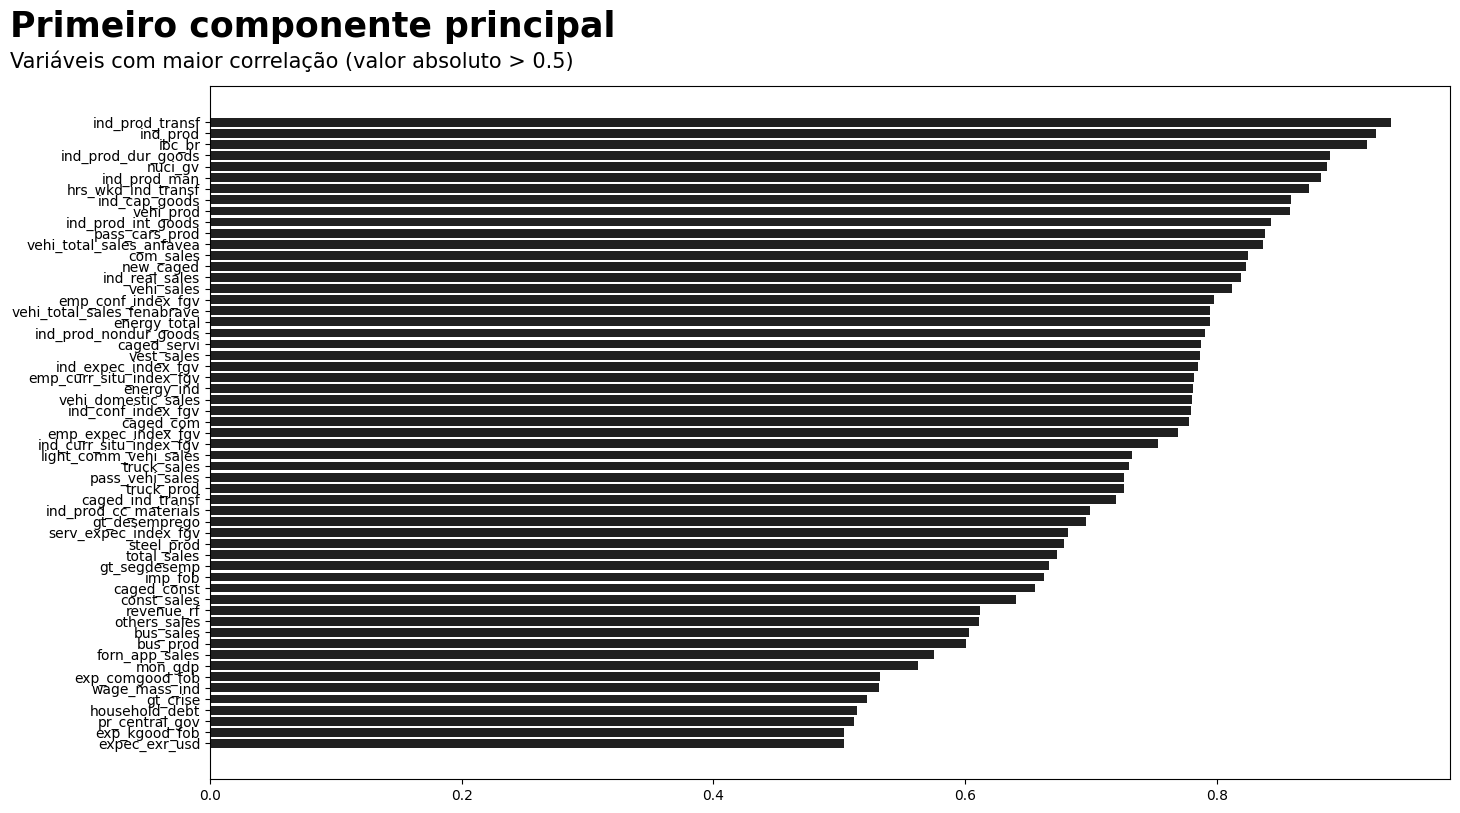

In [ ]:
# Principais variáveis do PRIMEIRO PC

# cores
BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"

fig, ax = plt.subplots(figsize=(16,9))
ax.barh(vars_c1, top_c1, align = "center", color = BLACK, )
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.invert_yaxis()

# Add title
fig.text(
    0, 0.935, "Primeiro componente principal", 
    fontsize=25, fontweight="bold", fontfamily="Econ Sans Cnd"
)
# Add subtitle
fig.text(
    0, 0.900, "Variáveis com maior correlação (valor absoluto > 0.5)", 
    fontsize=15, fontfamily="Econ Sans Cnd"
)
fig.set_facecolor("white")
fig.show()
# plt.savefig('dfm-images-plots/first_pc_correlations.png')

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\1975298638.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\1975298638.py:25: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.


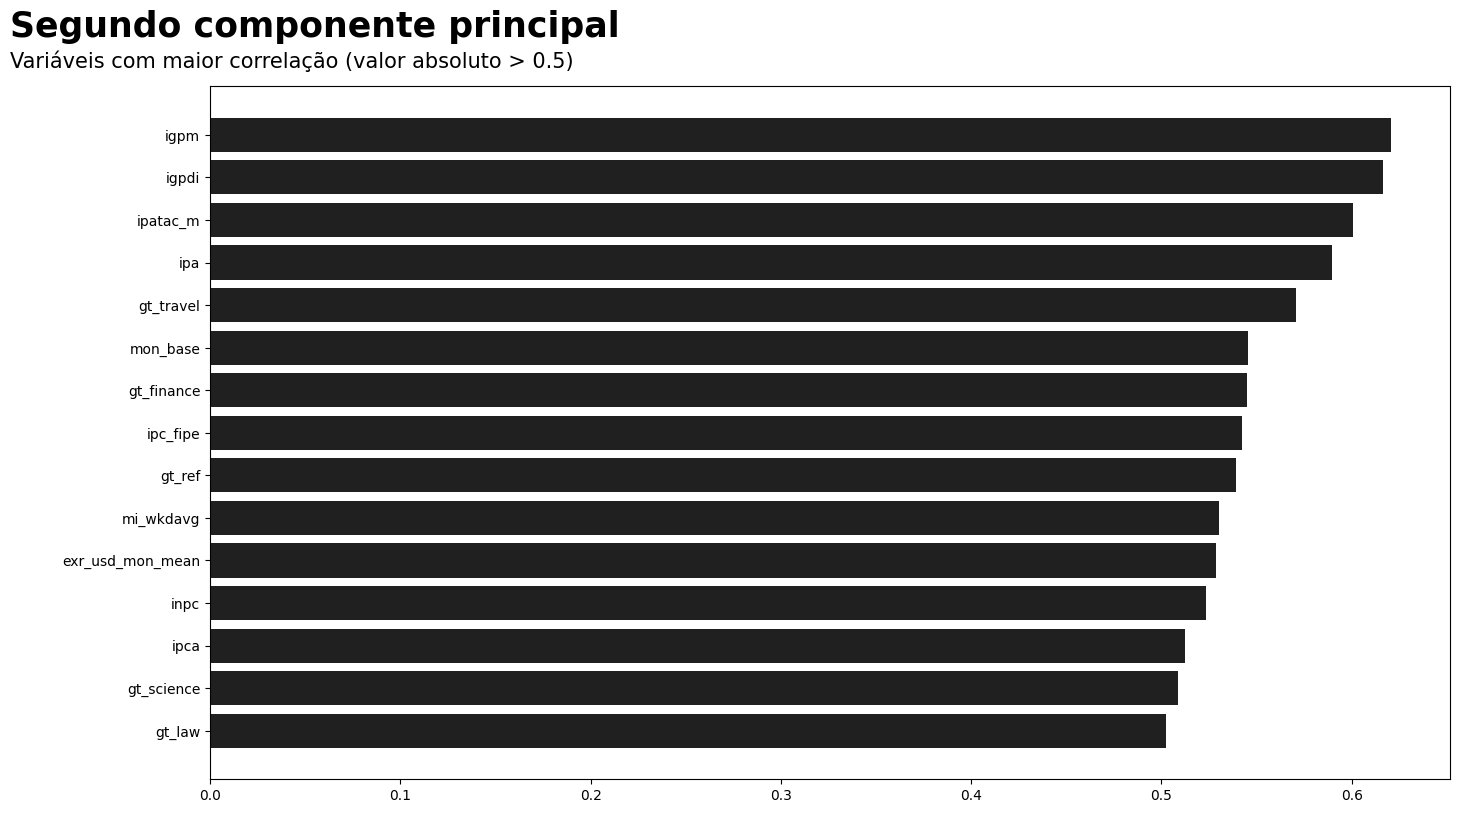

In [ ]:
# Principais variáveis do SEGUNDO PC

# cores
BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"

fig, ax = plt.subplots(figsize=(16, 9))
ax.barh(vars_c2, top_c2, align = "center", color = BLACK)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.invert_yaxis()

# Add title
fig.text(
    0, 0.935, "Segundo componente principal", 
    fontsize=25, fontweight="bold", fontfamily="Econ Sans Cnd"
)
# Add subtitle
fig.text(
    0, 0.900, "Variáveis com maior correlação (valor absoluto > 0.5)", 
    fontsize=15, fontfamily="Econ Sans Cnd"
)
fig.set_facecolor("white")
fig.show()
# plt.savefig('dfm-images-plots/second_pc_correlations.png')

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\3671088038.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\3671088038.py:25: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.


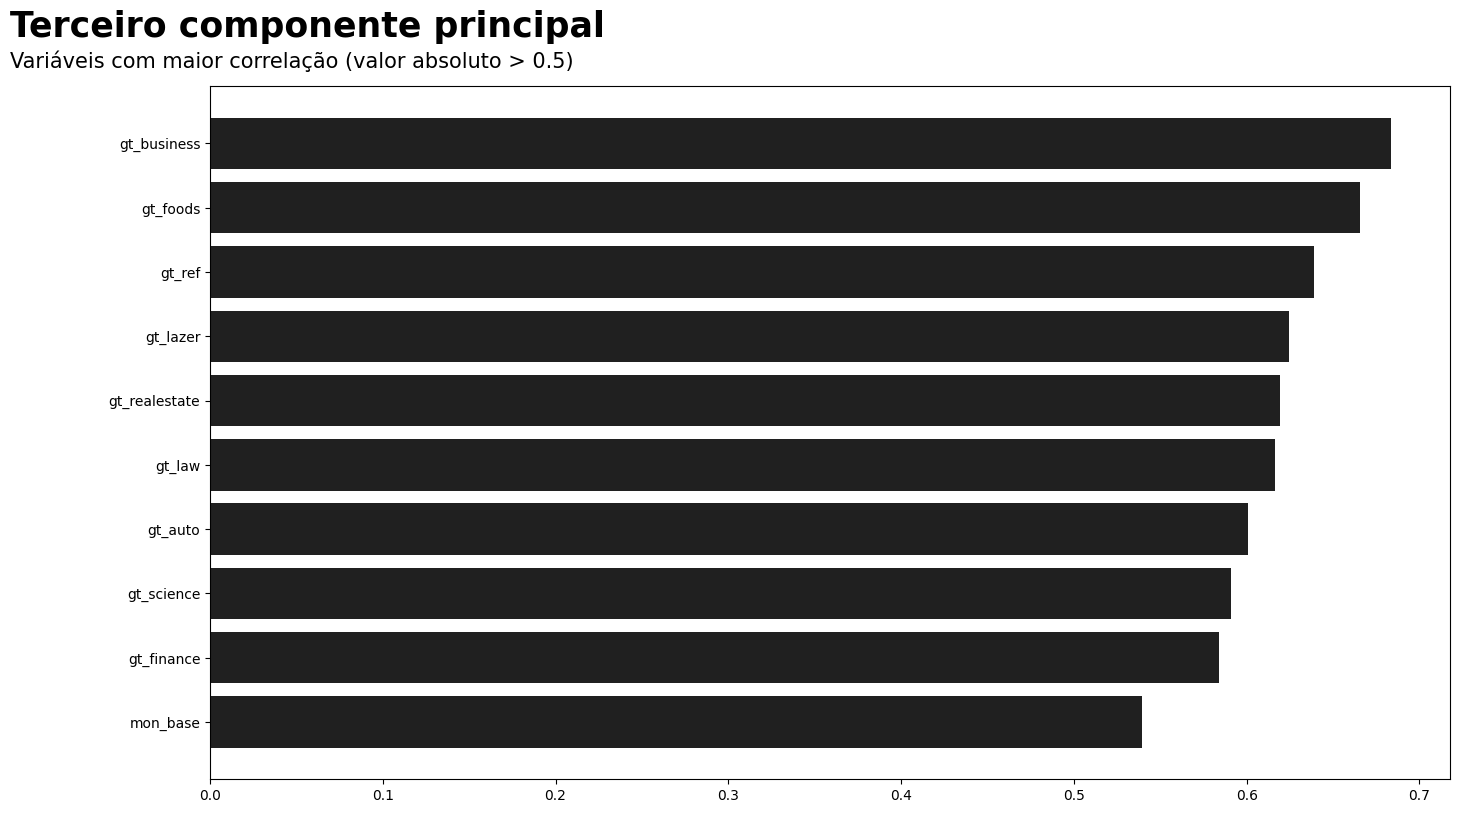

In [ ]:
# Principais variáveis do TERCEIRO PC

# cores
BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"

fig, ax = plt.subplots(figsize=(16, 9))
ax.barh(vars_c3, top_c3, align = "center", color = BLACK)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.invert_yaxis()

# Add title
fig.text(
    0, 0.935, "Terceiro componente principal", 
    fontsize=25, fontweight="bold", fontfamily="Econ Sans Cnd"
)
# Add subtitle
fig.text(
    0, 0.900, "Variáveis com maior correlação (valor absoluto > 0.5)", 
    fontsize=15, fontfamily="Econ Sans Cnd"
)
fig.set_facecolor("white")
fig.show()
# plt.savefig('dfm-images-plots/third_pc_correlations.png')

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\1117770639.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\1117770639.py:25: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.


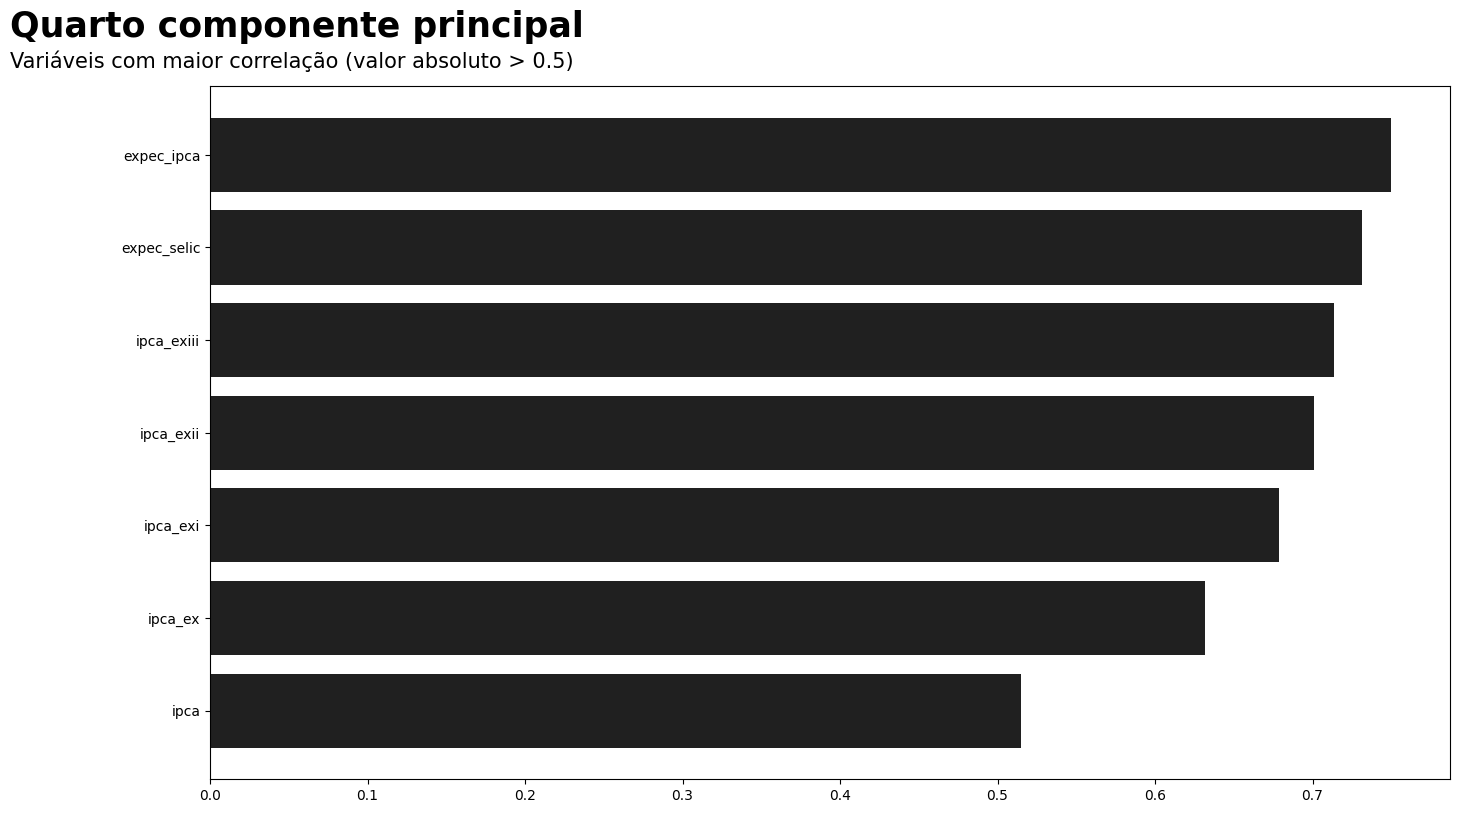

In [ ]:
# Principais variáveis do QUARTO PC

# cores
BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"

fig, ax = plt.subplots(figsize=(16, 9))
ax.barh(vars_c4, top_c4, align = "center", color = BLACK)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.invert_yaxis()

# Add title
fig.text(
    0, 0.935, "Quarto componente principal", 
    fontsize=25, fontweight="bold", fontfamily="Econ Sans Cnd"
)
# Add subtitle
fig.text(
    0, 0.900, "Variáveis com maior correlação (valor absoluto > 0.5)", 
    fontsize=15, fontfamily="Econ Sans Cnd"
)
fig.set_facecolor("white")
fig.show()
# plt.savefig('dfm-images-plots/fourth_pc_correlations.png')

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\3402533305.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Henri\AppData\Local\Temp\ipykernel_16864\3402533305.py:25: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.
findfont: Font family 'Econ Sans Cnd' not found.


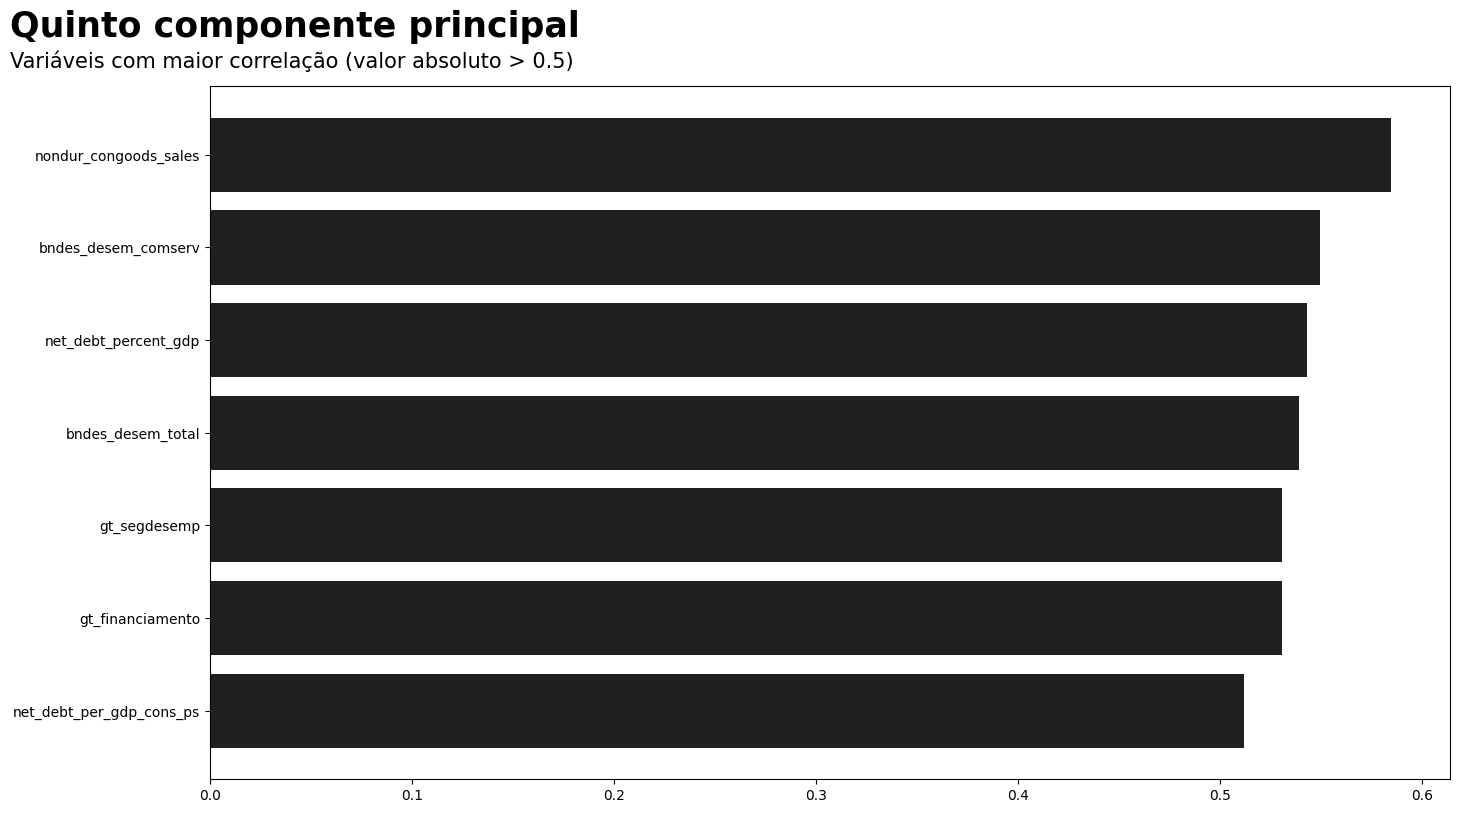

In [ ]:
# Principais variáveis do QUINTO PC

# cores
BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"

fig, ax = plt.subplots(figsize=(16, 9))
ax.barh(vars_c5, top_c5, align = "center", color = BLACK)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.invert_yaxis()

# Add title
fig.text(
    0, 0.935, "Quinto componente principal", 
    fontsize=25, fontweight="bold", fontfamily="Econ Sans Cnd"
)
# Add subtitle
fig.text(
    0, 0.900, "Variáveis com maior correlação (valor absoluto > 0.5)", 
    fontsize=15, fontfamily="Econ Sans Cnd"
)
fig.set_facecolor("white")
fig.show()
# plt.savefig('dfm-images-plots/fifth_pc_correlations.png')

array([[<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
       [<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>]],
      dtype=object)

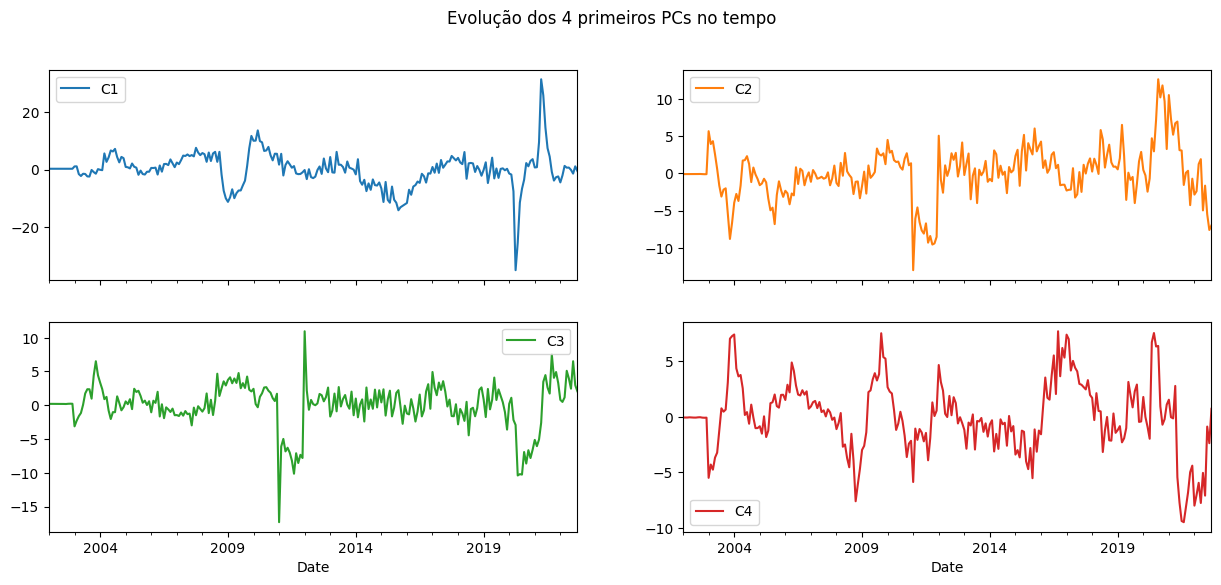

In [ ]:
data_pca_df.loc[:, 'C1':'C4'].plot(subplots=True, layout=(2, 2), figsize=(15, 6), title = 'Evolução dos 4 primeiros PCs no tempo')

In [25]:
# Definindo dataframe com os pesos das variáveis em valor absoluto 
absolute_eigenvectors_df = abs(eigvectors_df).T
absolute_eigenvectors_df = pd.merge(absolute_eigenvectors_df, map_comp, left_index=True, right_index=True)
absolute_eigenvectors_df.reset_index(inplace = True)
absolute_eigenvectors_df.drop('index', axis = 1, inplace = True)

# Somando os pesos em valor absoluto por categoria/grupo de variáveis
comp_group_share = absolute_eigenvectors_df.groupby('category').sum()

# Transformando os pesos somados por categoria em porcentagem da soma total dos pesos
for i in list(comp_group_share.columns):
    comp_group_share[i] = comp_group_share[i].apply(lambda x: x / comp_group_share[i].sum())

comp_group_share = comp_group_share.iloc[:, : 13]
comp_group_share.columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
comp_group_share = comp_group_share.T
comp_group_share

category,Energy,Expectations,Financial,Google Trends,International,Labor Market,Prices,Production,Public Sector,Sales
C1,0.069060,0.114291,0.066604,0.127563,0.048676,0.087735,0.057915,0.219481,0.028382,0.180295
C2,0.062789,0.080172,0.091915,0.282227,0.038212,0.044863,0.226054,0.059934,0.041476,0.072357
C3,0.061212,0.048967,0.102760,0.426839,0.018192,0.012777,0.171302,0.047599,0.044518,0.065835
C4,0.049681,0.154060,0.102316,0.217210,0.033045,0.056246,0.194918,0.057943,0.067309,0.067273
C5,0.057118,0.115233,0.114958,0.216938,0.023948,0.066308,0.102610,0.079841,0.083532,0.139513
C6,0.103146,0.102599,0.103633,0.354827,0.058063,0.038389,0.062579,0.080982,0.017157,0.078626
C7,0.068074,0.134665,0.086000,0.430395,0.031522,0.020828,0.058114,0.065191,0.021448,0.083764
C8,0.107907,0.104004,0.126459,0.233709,0.054959,0.038237,0.097736,0.075052,0.037100,0.124838
C9,0.091890,0.099666,0.163495,0.170377,0.035408,0.031662,0.210406,0.081991,0.049487,0.065617


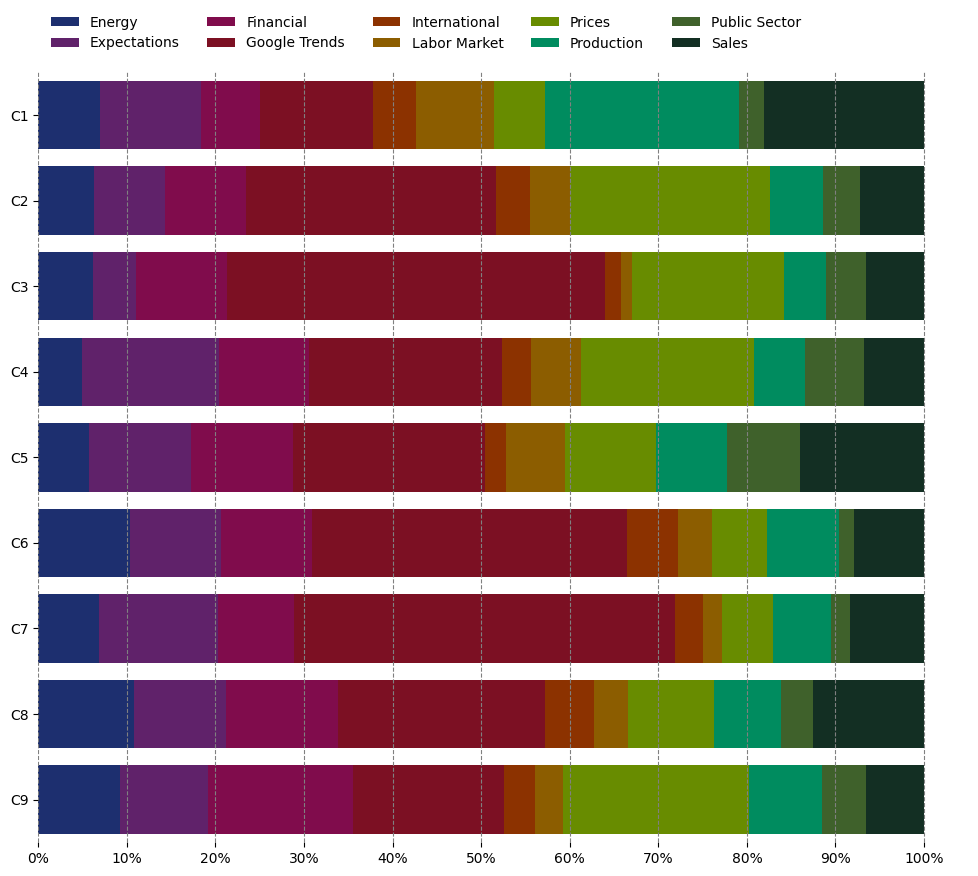

In [27]:
# variables
labels = list(comp_group_share.columns)
colors = ['#1d2f6f', '#60226a', '#800c4c', '#7c1023', '#8c3200', '#8c5d00', '#688c00', '#008c5f', '#3f612b', '#132f23']
title = ' '

# Definindo a função
def plot_stackedbar_p(df, labels, colors, title):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
# title and subtitle
    plt.title(title, loc='left')
# legend
    plt.legend(labels, bbox_to_anchor=([0, 1, 0, 0.09]), loc = 2, ncol=5, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,1.1,0.1)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.invert_yaxis()
plt.show()
    
plot_stackedbar_p(comp_group_share, labels, colors, title)
plt.savefig('DFM-PLOTS-FULL/DFM-FULL-PCA-Comp-Share.png')

# Teste de estacionariedade dos fatores (componentes)

In [ ]:
# Realizando o teste ADF 1 

adf_tf = pd.DataFrame()
cols = data_pca_df.columns

for column in cols:
  adf_test = adfuller_test1(data_pca_df[column].dropna())
  adf_tf[column] = adf_test

adf_tf_t = adf_tf.T
adf_tf_t[adf_tf_t['reject_005'] == False]

,test_statistic,p_value,n_lags,n_observations,reject_005,Critical value 1%,Critical value 5%,Critical value 10%


In [ ]:
# Realizando o teste ADF 2 

adf_tf = pd.DataFrame()
cols = data_pca_df.columns

for column in cols:
  adf_test = adfuller_test2(data_pca_df[column].dropna())
  adf_tf[column] = adf_test

adf_tf_t = adf_tf.T
adf_tf_t[adf_tf_t['reject_005'] == False]

,test_statistic,p_value,n_lags,n_observations,reject_005,Critical value 1%,Critical value 5%,Critical value 10%
C5,-2.803058,0.057838,12,236,False,-3.458366,-2.873866,-2.573339
C8,-2.373455,0.149369,14,234,False,-3.458608,-2.873972,-2.573396


In [ ]:
# Realizando o teste ADF 3 

adf_tf = pd.DataFrame()
cols = data_pca_df.columns

for column in cols:
  adf_test = adfuller_test3(data_pca_df[column].dropna())
  adf_tf[column] = adf_test

adf_tf_t = adf_tf.T
adf_tf_t[adf_tf_t['reject_005'] == False]

,test_statistic,p_value,n_lags,n_observations,reject_005,Critical value 1%,Critical value 5%,Critical value 10%
C5,-3.316748,0.063545,12,236,False,-3.997651,-3.429259,-3.138078
C8,-3.01823,0.127055,14,234,False,-3.997988,-3.429421,-3.138173


> Os Fatores são considerados estacionários independentemente da configuração de teste ADF que usamos (1, 2, 3).